# Make Sure the ML Model Fitted Correctly

In [1]:
# Create a strategy using the trained model
# Backtest using timerange TRAINVAL, and pairs of trained model
# Make sure the profit graph is upwards (ofc coz we BT'ed in train and val date)

In [7]:
%load_ext autoreload
%autoreload 2
%env WANDB_SILENT=true

from pathlib import Path
from copy import deepcopy
import matplotlib.pyplot as plt
import pandas as pd
import quantstats as qs
import os
import logging
import sys
import nest_asyncio

nest_asyncio.apply()

while "freqtrade" not in os.listdir():
    os.chdir("..")
    if "freqtrade" in os.listdir():
        nest_asyncio.apply()
        logger = logging.getLogger("freqtrade.nbtools")
        handler = logging.StreamHandler(stream=sys.stdout)
        handler.setFormatter(logging.Formatter("%(name)s - %(message)s"))
        logger.addHandler(handler)
        logger.setLevel(logging.DEBUG)

# Freqtrade Imports
from freqtrade.optimize.optimize_reports import text_table_add_metrics
from freqtrade.nbtools.preset import ConfigPreset
from freqtrade.nbtools.backtest import backtest
from freqtrade.nbtools.remote_utils import load_lightning_container
from freqtrade.nbtools.helper import get_function_body
from freqtrade.nbtools import plotting, configs
from freqtrade.ml import lightning_utils

# Constants
PATH_MOUNT = Path.cwd().parent / "mount"

# Custom function
def string_templating(string: str, data: dict, strip_doublequotes=False):
    _string = deepcopy(string)
    """Replace [|key|] in string with data["key"] """
    for key, value in data.items():
        to_replace = "[|{}|]".format(key)
        if strip_doublequotes:
            to_replace = "\"[|{}|]\"".format(key)
        if to_replace not in string:
            raise Exception(f"Not found formatting with key '{key}'")
        _string = _string.replace(to_replace, str(value))
    return _string

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: WANDB_SILENT=true


In [2]:
# NOTE: Last run is for "5n20-catboosttest"

def strategy_func():
    """ Start Strategy Code """
    from freqtrade.nbtools.strategy import INbStrategy
    from freqtrade.nbtools.remote_utils import load_lightning_container
    from freqtrade.ml.container import LightningContainer
    from pandas import DataFrame
    import numpy as np  # noqa
    import pandas as pd  # noqa
    import talib.abstract as ta
    
    LIGHTNING_CONTAINER_NAME = "[|LIGHTNING_CONTAINER_NAME|]"
    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version="latest")        
    
    
    class NotebookStrategy(INbStrategy):
        # These attributes are REQUIRED!
        timeframe = lightning_container.module.config.timeframe
        minimal_roi = {"0": 99}
        stoploss = -0.99
        startup_candle_count: int = 500
                    
        def populate_indicators(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            dataframe = lightning_container.predict(dataframe)
            return dataframe

        def populate_buy_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            dataframe.loc[
                (
                    (dataframe['ml_2'] > 0.55) &
                    (dataframe['volume'] > 0)  # Make sure Volume is not 0
                ),
                'buy'] = 1
            return dataframe

        def populate_sell_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            num_candles_forward: int = lightning_container.module.config.num_future_candles
            dataframe.loc[
                (
                    ( (dataframe['ml_0'] > 0.7) | (dataframe['buy'].shift(num_candles_forward) == 1) ) &
                    (dataframe['volume'] > 0)  # Make sure Volume is not 0
                ),
                'sell'] = 1
            return dataframe
    """ End Strategy Code """

In [8]:
PATH_LOCAL_DATADIR = PATH_MOUNT / "data"
LIGHTNING_CONTAINER_NAME = "5n20-catboosttest"

lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version="latest")
preset = ConfigPreset(
    name=LIGHTNING_CONTAINER_NAME,
    config_dict = configs.DEFAULT,
    path_data=PATH_LOCAL_DATADIR,
    timerange=lightning_utils.get_timerange_trainval(lightning_container)
)
preset.overwrite_config(pairs=lightning_container.module.config.pairs)

strategy_code = string_templating(
    get_function_body(strategy_func),
    data={"LIGHTNING_CONTAINER_NAME": LIGHTNING_CONTAINER_NAME}
)
stats, summary = backtest(preset, strategy_code)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])

freqtrade.nbtools.preset.config_preset - Preparing ConfigPreset for `5n20-catboosttest`
freqtrade.nbtools.preset.base_preset - Setting config for 5n20-catboosttest ...
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 5 pairs)
freqtrade.nbtools.preset.base_preset - Setting arg `datadir` to C:\CS\Python\crypto-collection\freqtrade\mount\data\binance
freqtrade.nbtools.preset.base_preset - Setting arg `timerange` to 20210412-20210611
freqtrade.nbtools.backtest - Backtesting...
freqtrade.nbtools.backtest - Strategy using minimal_roi: {'0': 99}
freqtrade.nbtools.backtest - Strategy using timeframe: 5m
freqtrade.nbtools.backtest - Strategy using stoploss: -0.99
freqtrade.nbtools.backtest - Strategy using trailing_stop: False
freqtrade.nbtools.backtest - Strategy using trailing_stop_positive_offset: 0.0
freqtrade.nbtools.backtest - Strategy using trailing_only_offset_is_reached: False
freqtrade.nbtools.backtest - Strategy using use_custom_stoploss: False
freqtrade.nbtools.ba

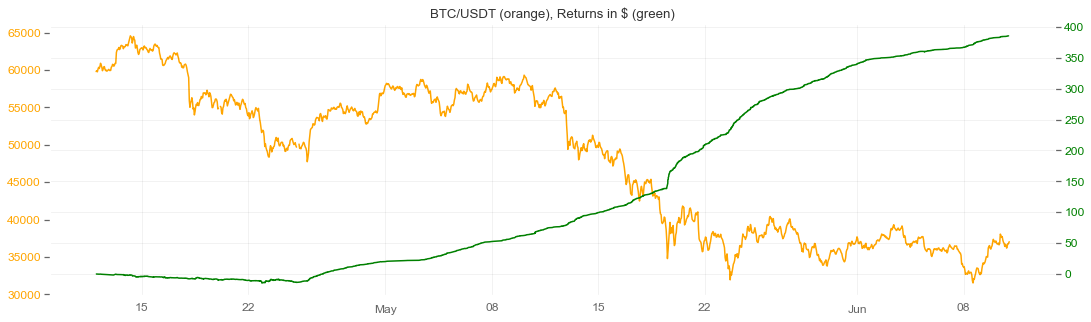

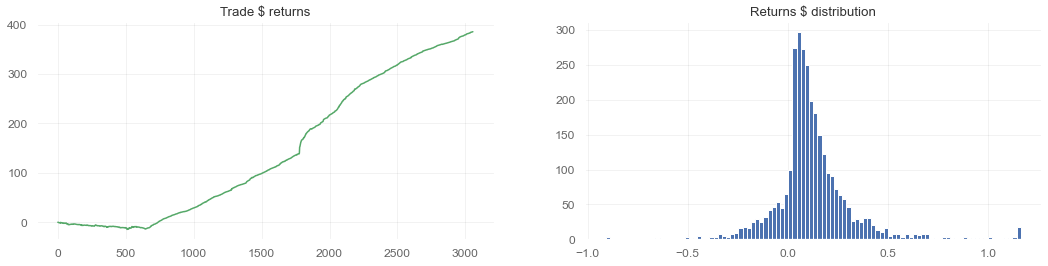

,Portfolio Summary
Min Balance,-14.49
Max Balance,385.58
End Balance,385.58
Trades,3056.00
Avg. Profit %,0.84
Avg. Profit $,0.13
Biggest Profit $,6.94
Biggest Loss $,-1.58


In [9]:
plotting.plot_profits_timerange(
    trades,
    timerange = preset.timerange,
    path_mount = PATH_MOUNT
)